# blocking identification 
### contrack - VAPV (some spatial pattern, why???)

In [1]:
from contrack import contrack
import xarray as xr
import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from matplotlib import cm

In [2]:
#### FUNCTIONS #####
def print_now():
    print('time:'+str(datetime.datetime.now()))


In [14]:
####====INPUT
xr_in=xr.open_mfdataset('/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production-hist/vapv/IFS_9-FESOM_5-production-hist_vapv-201*',concat_dim='time',combine='nested')

In [15]:
xr_in

<xarray.Dataset>
Dimensions:    (latitude: 181, longitude: 360, time: 14608)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 ... 2019-12-31T18:00:00
  * latitude   (latitude) float64 -90.0 -89.0 -88.0 -87.0 ... 88.0 89.0 90.0
  * longitude  (longitude) float64 -180.0 -179.0 -178.0 ... 177.0 178.0 179.0
Data variables:
    VAPV       (time, latitude, longitude) float64 dask.array<chunksize=(124, 181, 360), meta=np.ndarray>

In [16]:
###===OUTPUT
outpath = '/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production-hist/block/ANO_VAPV'

###==subfix era5
subfix='-ifs-ano_2010-2019'


###OUTFILE NAME
outfile_flag='BLOCKS'+subfix+'.nc'
outfile_table='BLOCKS'+subfix+'.csv'

In [17]:
### intitate

In [18]:
block = contrack()
block.read_xarray(xr_in)

In [19]:
block.set_up(force=True)
block.ds = block.ds.compute() ### look at this!

INFO: 
 time: 'time'
 longitude: 'longitude'
 latitude: 'latitude'



In [20]:
### compute anomalies
print_now()
print('computing vapv clim/anom')
block.calc_anom(variable='VAPV',
        smooth=8,
        window=31,
        groupby='dayofyear')


INFO: Set up dimensions...
INFO: 
 time: 'time'
 longitude: 'longitude'
 latitude: 'latitude'

INFO: Calculating climatological mean from VAPV...


time:2024-07-22 16:58:21.541477
computing vapv clim/anom


INFO: Calculating Anomaly... DONE


In [21]:
####Identify and track blocks
block.run_contrack(variable='anom',
                   threshold=-1,
                   gorl='<=',
                   overlap=0.7,
                   persistence=20,
                   twosided=True)

INFO: 
Run ConTrack 
########### 
    threshold:    <= -1 
    overlap:      0.7 
    persistence:  20 time steps
INFO: Set up dimensions...
INFO: 
 time: 'time'
 longitude: 'longitude'
 latitude: 'latitude'

INFO: Find individual contours...
INFO: Apply overlap...
INFO: Apply persistence...
INFO: Create new variable 'flag'...
INFO: Running contrack... DONE
1835 contours tracked


In [22]:
# save to disk
block['flag'].to_netcdf(outpath+'/'+outfile_flag,unlimited_dims='time')

###==== flag = output of block.run_contrack(), variable = input variable to calculate intensity and center of mass
block_df = block.run_lifecycle(flag='flag', variable='anom')
block_df.to_csv(outpath+'/'+outfile_table, index=False)

INFO: 
Run Lifecycle 
########### 
    flag:    flag
    variable:    anom
INFO: Set up dimensions...
INFO: 
 time: 'time'
 longitude: 'longitude'
 latitude: 'latitude'



In [23]:
#block

In [3]:
ifs=xr.open_mfdataset('/scratch/b/b382006/nextgems/prefinal/IFS_9-FESOM_5-production-hist/block/ANO_VAPV/BLOCKS-*nc')

OSError: no files to open

In [27]:
sample=ifs
# select only winter months January, February and December
### select seasons
sufix='summer'
if sufix=='winter':
    season=[10,11,12,1,2,3]
if sufix=='summer':
    season=[4,5,6,7,8,9]
    
##== annual
blocks_sims = sample
##==season
#blocks_sims = sample.sel(time=sample.time.dt.month.isin(season))

ntime_sims=len(blocks_sims.time)

### accumulate 
ntime_sims =len(blocks_sims.time)
acc_ifs = xr.where(blocks_sims['flag']>1,1,0).sum(dim='time')/ntime_sims*100
#acc_ifs=(xr.where(block['flag']>1,1,0).sum(dim='time')/block.ntime*100)

In [29]:
# save to disk
era5=xr.open_mfdataset('/work/bm1235/b382006/era5/block/ANO_VAPV/BLOCKS-era5-ano_*.nc')

sample=era5.sel(time=slice('1990','2019'))

#sample

# select only winter months January, February and December
### select seasons
sufix='summer'
if sufix=='winter':
    season=[10,11,12,1,2,3]
if sufix=='summer':
    season=[4,5,6,7,8,9]
    
##== annual
blocks_sims = sample
##==season
#blocks_sims = sample.sel(time=sample.time.dt.month.isin(season))

ntime_sims=len(blocks_sims.time)

### accumulate 
ntime_sims =len(blocks_sims.time)
acc_sims = xr.where(blocks_sims['flag']>1,1,0).sum(dim='time')/ntime_sims*100

/home/b/b382006/.conda/envs/contrack_dev/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/b/b382006/.conda/envs/contrack_dev/lib/python3.8/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/b/b382006/.conda/envs/contrack_dev/lib/python3.8/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/b/b382006/.co

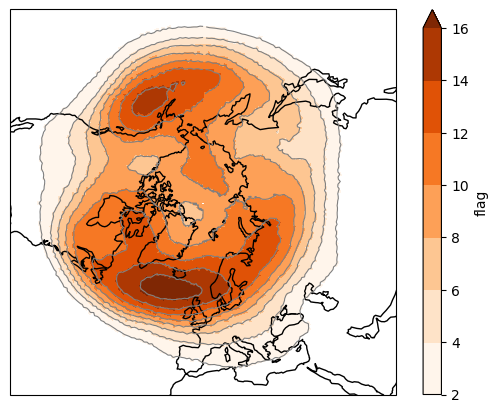

In [30]:
# plotting blocking frequency (in %) for winter over Northern Hemisphere
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

#fig, ax = plt.subplots(figsize=(7, 5), subplot_kw={'projection': ccrs.NorthPolarStereo()})
#(xr.where(block['flag']>1,1,0).sum(dim='time')/block.ntime*100).plot(levels=np.arange(2,18,2), cmap='Oranges', extend = 'max', transform=ccrs.PlateCarree())
#(xr.where(block['flag']>1,1,0).sum(dim='time')/block.ntime*100).plot.contour(colors='grey', linewidths=0.8, levels=np.arange(2,18,2), transform=ccrs.PlateCarree())
#ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree()); ax.coastlines();

fig, ax = plt.subplots(figsize=(7, 5), subplot_kw={'projection': ccrs.NorthPolarStereo()})
acc_ifs.plot(levels=np.arange(2,18,2), cmap='Oranges', extend = 'max', transform=ccrs.PlateCarree())
acc_ifs.plot.contour(colors='grey', linewidths=0.8, levels=np.arange(2,18,2), transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree()); ax.coastlines();

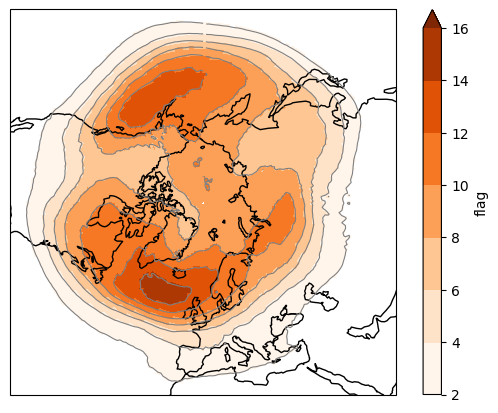

In [31]:
fig, ax = plt.subplots(figsize=(7, 5), subplot_kw={'projection': ccrs.NorthPolarStereo()})
acc_sims.plot(levels=np.arange(2,18,2), cmap='Oranges', extend = 'max', transform=ccrs.PlateCarree())
acc_sims.plot.contour(colors='grey', linewidths=0.8, levels=np.arange(2,18,2), transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree()); ax.coastlines();

/home/b/b382006/.conda/envs/contrack_dev/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/b/b382006/.conda/envs/contrack_dev/lib/python3.8/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/b/b382006/.conda/envs/contrack_dev/lib/python3.8/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/b/b382006/.co

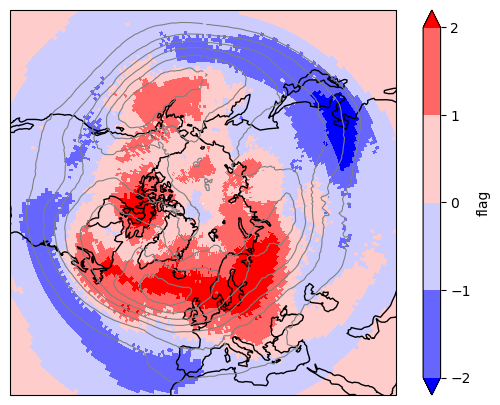

In [33]:
### Diff
fig, ax = plt.subplots(figsize=(7, 5), subplot_kw={'projection': ccrs.NorthPolarStereo()})
(acc_ifs-acc_sims).plot(levels=np.arange(-2,3,1), cmap='bwr', extend = 'both', transform=ccrs.PlateCarree())
acc_sims.plot.contour(colors='grey', linewidths=0.8, levels=np.arange(2,18,2), transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree()); ax.coastlines();

In [15]:
### Plot tracks

/home/b/b382006/.conda/envs/contrack_dev/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/b/b382006/.conda/envs/contrack_dev/lib/python3.8/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/b/b382006/.conda/envs/contrack_dev/lib/python3.8/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/home/b/b382006/.co

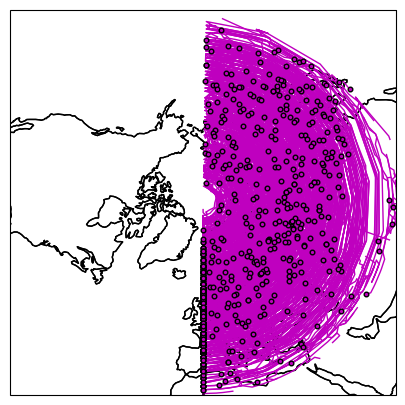

In [16]:
# plotting blocking track (center of mass) and genesis
f, ax = plt.subplots(1, 1, figsize=(7,5), subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
ax.set_extent([-180, 180, 30, 90], crs=ccrs.PlateCarree()); ax.coastlines()
ax.coastlines() # add coastlines

#need to split each blocking track due to longitude wrapping (jumping at map edge)
for bid in np.unique(np.asarray(block_df['Flag'])): #select blocking id
    lons = np.asarray(block_df['Longitude'].iloc[np.where(block_df['Flag']==bid)])
    lats = np.asarray(block_df['Latitude'].iloc[np.where(block_df['Flag']==bid)])

    # cosmetic: sometimes there is a gap near map edge where track is split:
    lons[lons >= 355] = 359.9
    lons[lons <= 3] = 0.1
    segment = np.vstack((lons,lats))

    #move longitude into the map region and split if longitude jumps by more than "threshold"
    lon0 = 0 #center of map
    bleft = lon0-0.
    bright = lon0+360
    segment[0,segment[0]> bright] -= 360
    segment[0,segment[0]< bleft]  += 360
    threshold = 180  # CHANGE HERE
    isplit = np.nonzero(np.abs(np.diff(segment[0])) > threshold)[0]
    subsegs = np.split(segment,isplit+1,axis=+1)

    #plot the tracks
    for seg in subsegs:
        x,y = seg[0],seg[1]
        ax.plot(x ,y,c = 'm',linewidth=1, transform=ccrs.PlateCarree())
    #plot the starting points
    ax.scatter(lons[0],lats[0],s=11,c='m', zorder=10, edgecolor='black', transform=ccrs.PlateCarree())